# Roberta hyperparameters
In this experiment, we will create two baseline machine learning models to predict the values, providing a foundation for future iterations.
Now that we have everything ready, we will export the dataset.

- **MODEL_NAME**: `"roberta-base"`
- **NAME_EXPERIMENTS**: `"Fake news comments"`
- **DATASET_NAME**: `"X_train_cleaned_2"`
- **HYPERPARAMETERS_EXPERIMENTS**: `20`
- **BATCH_SIZE**: `8`
- **NUM_LABELS**: `1`
- **EPOCHS**: `3`
- **THRESHOLD_PROBABILITIES_MODEL**: `0.5`
- **COMMENTS**: `"Some hyperparameter tuning with the clean dataset where we take out some values"`
- **PATIENCE_EARLY_STOP**: `3`
- **LEARNING_RATE**: `1e-10 to 1e-2`
- **WEIGHT_DECAY**: `1e-12 to 1e-2`
- **DROPOUT_VALUE**: `0.1 to 0.3`
- **WARMUP_RATIO**: `0.0 to 0.2`
- **OPTIMIZER_NAME**: `"AdamW"`, `"SGD"`, `"RMSprop"`


Also, we will be adding just 30% of the training dataset, but for the training we had all the dataset.

In [ ]:
%%capture
!pip install mlflow dagshub wandb optuna

In [ ]:
# Standard Library Imports
import math
import os
from typing import Dict, List

# Third-party Libraries
import mlflow
import mlflow.pytorch
import nltk
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import torch
import wandb
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score
from torch.optim import AdamW, RMSprop, SGD
from torch.utils.data import DataLoader, Dataset
from wordcloud import WordCloud

# Hugging Face Transformers
from transformers import (
    AdamW,
    AutoModel,
    AutoTokenizer,
    BertModel,
    BertTokenizer,
    get_linear_schedule_with_warmup
)

# PyTorch Libraries
import torch.nn as nn
import torch.nn.functional as F


# import google drive
from google.colab import drive, files
drive.mount('/content/drive')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

"""Import the modules from google colab"""
import sys
PATH_helper = "/content/drive/MyDrive/turing_college_experiments/16/helper"
sys.path.append(PATH_helper)
# Custom imports
from helper_eda import (proportion_balance_classes, extractions_text_description, histogram_bins,
                                plot_distribution_tokens_per_word, dimensionality_reduction_chart_tsne,
                               components_pca_3d_chart)

"""
Verify the cores and gpu in the colab
"""
num_cores = os.cpu_count()  # Get the number of CPU cores
print(f'Number of available CPU cores: {num_cores}')
NUM_WORKERS = num_cores - 1
print(f'Setting num_workers to: {NUM_WORKERS}')

num_gpus_colab = torch.cuda.device_count()
GPU_LIST = [torch.cuda.get_device_name(i) for i in range(num_gpus_colab)]
NUM_WORKERS, GPU_LIST

enable_code_paths = True
enable_block = False

# weight and biases
wandb.login()

# ml versioning control
import dagshub
import mlflow
import mlflow.sklearn
dagshub.init(repo_owner='auszed', repo_name='Experiments_fake_news', mlflow=True)

# tracking experiments
os.environ['MLFLOW_TRACKING_USERNAME'] = 'auszed'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '4390ce1796189f46f62a5e643463dcaffede3ebf'
os.environ['MLFLOW_TRACKING_URI'] = 'https://dagshub.com/auszed/Experiments_fake_news.mlflow'


# Download the stopwords if you haven't already
nltk.download('stopwords')

# Inline plotting for Jupyter Notebooks
%matplotlib inline
custom_colors = ['#36CE8A', "#7436F5","#3736F4",   "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
gradient_colors = [ "#36CE8A", '#7436F5']
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)
cmap_theme = LinearSegmentedColormap.from_list('custom_colormap', gradient_colors)

# File paths
X_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_train_cleaned_2.csv")
y_train = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_train.csv")
X_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_val_cleaned_2.csv")
y_val = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_val.csv")
X_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/X_test_cleaned_2.csv")
y_test = pd.read_csv("/content/drive/MyDrive/turing_college_experiments/16/dataset/y_test.csv")

X_train = X_train[["title_text_join"]]
X_val = X_val[["title_text_join"]]
X_test = X_test[["title_text_join"]]

print(X_train.shape,y_train.shape )
print(X_val.shape,y_val.shape )
print(X_test.shape,y_test.shape )
theme_color

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Number of available CPU cores: 12
Setting num_workers to: 11


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=fe656b57-85d5-4866-83ae-287216bdc403&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=7c36659b6bf4dbb8305b9ad1de0cde087d9a0a0703336218877edb42cdbcfbd5




Accessing as auszed

Initialized MLflow to track repo "auszed/Experiments_fake_news"

Repository auszed/Experiments_fake_news initialized!

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


(26759, 1) (26759, 1)
(5734, 1) (5734, 1)
(5735, 1) (5735, 1)


[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [ ]:
#@title sample dataset for experiments
# sample size
enable_samples: bool = True #@param
SAMPLE_PERCENTAGE_X_train = 0.3 #@param
SAMPLE_PERCENTAGE_X_val = 1 #@param
SAMPLE_PERCENTAGE_X_test = 1 #@param

MODEL_NAME = "roberta-base" #@param
VERSION_MODEL = "005" #@param
NAME_EXPERIMENTS = "Fake news comments" #@param
DATASET_NAME = "X_train_cleaned_2" #@param title
HYPERPARAMETERS_EXPERIMENTS = 20 #@param
BATCH_SIZE = 8 #@param
NUM_LABELS = 1 #@param
EPOCHS = 3 #@param
THRESHOLD_PROBABILITIES_MODEL = 0.5 #@param

COMMENTS = "Some parameter tunning with the clean dataset where we take out some values" #@param
# COMMENTS = "Experiment" #@param
PATIENCE_EARLY_STOP = 3 #@param
LEARNING_RATE_INIT = 1e-10 #@param
LEARNING_RATE_END = 1e-2 #@param
WEIGHT_DECAY_INIT = 1e-12 #@param
WEIGHT_DECAY_END = 1e-2 #@param
DROPOUT_VALUE_INIT = 0.1 #@param
DROPOUT_VALUE_END = 0.3 #@param
WARMUP_RATIO_INIT = 0.0 #@param
WARMUP_RATIO_END = 0.2 #@param
OPTIMIZER_NAME_1 = "AdamW" #@param
OPTIMIZER_NAME_2 = "SGD" #@param
OPTIMIZER_NAME_3 = "RMSprop" #@param

URL_SAVE_MODEL = f"/content/drive/MyDrive/turing_college_experiments/16/model_save/{MODEL_NAME}_{VERSION_MODEL}.pth"

if enable_samples:
    # Concatenating the datasets
    concat_values_train = pd.concat([X_train, y_train], axis=1)
    concat_values_val = pd.concat([X_val, y_val], axis=1)
    concat_values_test = pd.concat([X_test, y_test], axis=1)

    # Sampling the datasets
    concat_values_train = concat_values_train.sample(frac=SAMPLE_PERCENTAGE_X_train, random_state=42)
    concat_values_val = concat_values_val.sample(frac=SAMPLE_PERCENTAGE_X_val, random_state=42)
    concat_values_test = concat_values_test.sample(frac=SAMPLE_PERCENTAGE_X_test, random_state=42)

    # Resetting the index without using inplace
    concat_values_train = concat_values_train.reset_index(drop=True)
    concat_values_val = concat_values_val.reset_index(drop=True)
    concat_values_test = concat_values_test.reset_index(drop=True)

    # Extracting features and targets
    X_train = pd.DataFrame(concat_values_train["title_text_join"])
    X_val = pd.DataFrame(concat_values_val["title_text_join"])
    X_test = pd.DataFrame(concat_values_test["title_text_join"])

    y_train = pd.DataFrame(concat_values_train["target_variable"])
    y_val = pd.DataFrame(concat_values_val["target_variable"])
    y_test = pd.DataFrame(concat_values_test["target_variable"])


print("TRAIN Dataset: {}".format(X_train.shape))
print("VALIDATION Dataset: {}".format(X_val.shape))
print("TEST Dataset: {}".format(X_test.shape))
print("TRAIN Dataset y: {}".format(y_train.shape))
print("VALIDATION Dataset y: {}".format(y_val.shape))
print("TEST Dataset y: {}".format(y_test.shape))

sample_data = 5 #@param
X_train.sample(sample_data)

TRAIN Dataset: (8028, 1)
VALIDATION Dataset: (5734, 1)
TEST Dataset: (5735, 1)
TRAIN Dataset y: (8028, 1)
VALIDATION Dataset y: (5734, 1)
TEST Dataset y: (5735, 1)


,title_text_join
3685,"china ope mocks turning rooster , ’ hilario lo..."
4733,"u.s. spy chief 'resolute ' rsia cyber attack ,..."
6727,bernie vows keep fighting despite huge super t...
4331,‘ apprentice ’ contestants reveal shocking inf...
5519,": u.s. , southeast asia advance 'shared visio..."


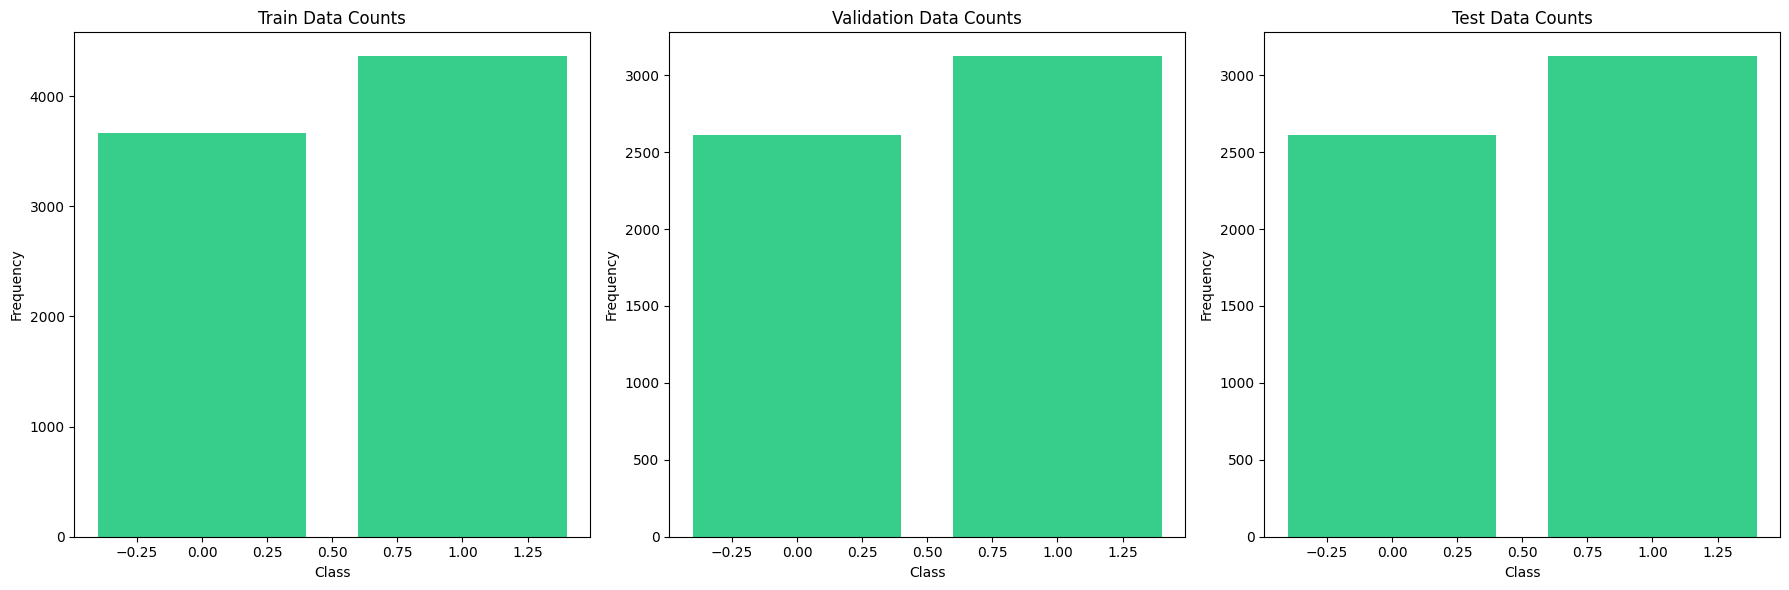

In [ ]:
#@title Split of the dataset
# Get counts for each dataset
train_counts = y_train.value_counts().reset_index()
val_counts = y_val.value_counts().reset_index()
test_counts = y_test.value_counts().reset_index()
train_counts.columns = ['Class', 'Frequency']
val_counts.columns = ['Class', 'Frequency']
test_counts.columns = ['Class', 'Frequency']

real_values = train_counts['Frequency'][0]
fake_values = train_counts['Frequency'][1]
total_values = train_counts['Frequency'].sum()
real_percentage = (real_values / total_values)
fake_percentage = (fake_values / total_values)

normalized_weights = torch.tensor([real_percentage, fake_percentage], dtype=torch.float)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Plot for train data
ax[0].bar(train_counts['Class'], train_counts['Frequency'])
ax[0].set_title('Train Data Counts')
ax[0].set_xlabel('Class')
ax[0].set_ylabel('Frequency')

# Plot for validation data
ax[1].bar(val_counts['Class'], val_counts['Frequency'])
ax[1].set_title('Validation Data Counts')
ax[1].set_xlabel('Class')
ax[1].set_ylabel('Frequency')

# Plot for test data
ax[2].bar(test_counts['Class'], test_counts['Frequency'])
ax[2].set_title('Test Data Counts')
ax[2].set_xlabel('Class')
ax[2].set_ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

In [ ]:
#@title Dataloader
class CustomDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, comment_str_title: str, tokenizer, target_variable: pd.DataFrame, max_token_len=256):

        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len
        self.target_variable = target_variable
        self.comment_str_title = comment_str_title

    def chunk_text(self, text, max_length, stride):
        tokens = self.tokenizer.encode_plus(
            text,
            add_special_tokens=False,
            max_length=None,
            truncation=False,
            return_attention_mask=False,
            return_token_type_ids=False
        )['input_ids']

        chunks = []
        for i in range(0, len(tokens), stride):
            chunk = tokens[i:i + max_length]
            if len(chunk) < max_length:
                chunk += [self.tokenizer.pad_token_id] * (max_length - len(chunk))  # Padding
            chunks.append(chunk)
        return chunks

    def __len__(self):
        """Length of the dataset"""
        return len(self.dataframe)

    def __getitem__(self, index):
        """Get a single item"""
        data_row = self.dataframe.iloc[index]
        comment = str(data_row[self.comment_str_title])
        data_row_target = torch.tensor(self.target_variable.iloc[index].values, dtype=torch.float)

        # Split the comment into chunks
        chunks = self.chunk_text(comment, max_length=self.max_token_len, stride=self.max_token_len // 2)

        input_ids = []
        attention_masks = []

        for chunk in chunks:
            # Here, `chunk` is already tokenized, so we directly create tensors
            tokens = {
                "input_ids": torch.tensor(chunk, dtype=torch.long),
                "attention_mask": torch.tensor([1 if id != self.tokenizer.pad_token_id else 0 for id in chunk], dtype=torch.long)
            }
            input_ids.append(tokens["input_ids"])
            attention_masks.append(tokens["attention_mask"])

        return {
            "input_ids": torch.stack(input_ids),
            "attention_masks": torch.stack(attention_masks),
            "labels": data_row_target
        }

# Model configuration
model_name = MODEL_NAME
tokenizer_model = AutoTokenizer.from_pretrained(model_name)

# dataloaders for training, val, test
dataset_loader_X_train = CustomDataset(
    dataframe=X_train,
    comment_str_title='title_text_join',
    target_variable=y_train,
    tokenizer=tokenizer_model,
    max_token_len=256
)
dataset_loader_X_val = CustomDataset(
    dataframe=X_val,
    comment_str_title='title_text_join',
    target_variable=y_val,
    tokenizer=tokenizer_model,
    max_token_len=256
)
dataset_loader_X_test = CustomDataset(
    dataframe=X_test,
    comment_str_title='title_text_join',
    target_variable=y_test,
    tokenizer=tokenizer_model,
    max_token_len=256
)

# Test the dataset
print("Dataset train length:", len(dataset_loader_X_train))
print("Dataset val length:", len(dataset_loader_X_val))
print("Dataset test length:", len(dataset_loader_X_test))
sample = dataset_loader_X_train[0]
print("Sample input IDs shape:", sample["input_ids"].shape)
print("Sample attention masks shape:", sample["attention_masks"].shape)
print("Sample labels:", sample["labels"])


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors


Dataset train length: 8028
Dataset val length: 5734
Dataset test length: 5735
Sample input IDs shape: torch.Size([5, 256])
Sample attention masks shape: torch.Size([5, 256])
Sample labels: tensor([1.])


In [ ]:
#@title Batches
def custom_collate_fn(batch: List[Dict]) -> Dict:
    """
    Custom collate function to handle variable number of chunks per sample.
    """
    # Get the max number of chunks in this batch
    max_chunks = max(sample["input_ids"].size(0) for sample in batch)

    # Get batch size and sequence length
    batch_size = len(batch)
    seq_length = batch[0]["input_ids"].size(1)

    # Initialize tensors to hold padded data
    padded_input_ids = torch.zeros((batch_size, max_chunks, seq_length), dtype=torch.long)
    padded_attention_masks = torch.zeros((batch_size, max_chunks, seq_length), dtype=torch.long)

    # Collect labels
    labels = torch.stack([sample["labels"] for sample in batch])

    # Create chunk attention mask to identify valid chunks
    chunk_attention_mask = torch.zeros((batch_size, max_chunks), dtype=torch.long)

    # Fill in the tensors with actual data
    for i, sample in enumerate(batch):
        num_chunks = sample["input_ids"].size(0)
        padded_input_ids[i, :num_chunks, :] = sample["input_ids"]
        padded_attention_masks[i, :num_chunks, :] = sample["attention_masks"]
        chunk_attention_mask[i, :num_chunks] = 1

    return {
        "input_ids": padded_input_ids,
        "attention_masks": padded_attention_masks,
        "chunk_attention_mask": chunk_attention_mask,
        "labels": labels
    }


# Create DataLoader with custom collate function
train_loader = DataLoader(
    dataset=dataset_loader_X_train,
    batch_size=BATCH_SIZE,  # Adjust based on your GPU memory
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,  # Adjust based on your CPU cores
    pin_memory=True,  # Set to True if using GPU
    drop_last=True
)
val_loader = DataLoader(
    dataset=dataset_loader_X_val,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)
test_loader = DataLoader(
    dataset=dataset_loader_X_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=custom_collate_fn,
    num_workers= NUM_WORKERS,
    pin_memory=True,
    drop_last=True
)

print(len(train_loader), "train_loader batch")
print(len(val_loader), "val_loader batch")
print(len(test_loader), "test_loader batch")

1003 train_loader batch
716 val_loader batch
716 test_loader batch


In [ ]:
# value_review = 22
# print(X_train.iloc[value_review])
# print(y_train.iloc[value_review])
# dataset_loader_X_train.__getitem__(value_review)

In [ ]:
#@title Model architecture

class ClassifierModel(nn.Module):
    def __init__(self, config):
        super(ClassifierModel, self).__init__()
        self.config = config

        # Pretrained model
        self.pretrained_model = AutoModel.from_pretrained(config['model_name'], return_dict=True)

        # Layers
        self.hidden = nn.Linear(self.pretrained_model.config.hidden_size, self.pretrained_model.config.hidden_size)
        self.classification = nn.Linear(self.pretrained_model.config.hidden_size, self.config['n_labels'])

        # Initialize weights
        nn.init.xavier_uniform_(self.hidden.weight)  # Use Xavier initialization
        nn.init.zeros_(self.hidden.bias)  # Initialize bias to zero
        nn.init.xavier_uniform_(self.classification.weight)  # Use Xavier initialization
        nn.init.zeros_(self.classification.bias)  # Initialize bias to zero

        # Loss function
        # self.loss_function = nn.BCEWithLogitsLoss(weight=normalized_weights)
        self.loss_function = nn.BCEWithLogitsLoss()

        # Dropout
        self.dropout = nn.Dropout(config['dropout_vals'])

    def forward(self, input_ids, attention_mask, chunk_attention_mask=None):
        batch_size, num_chunks, seq_length = input_ids.size()
        input_ids = input_ids.view(-1, seq_length)
        attention_mask = attention_mask.view(-1, seq_length)

        # Forward pass through the pretrained model
        output = self.pretrained_model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = torch.mean(output.last_hidden_state, 1)
        pooled_output = pooled_output.view(batch_size, num_chunks, -1)
        pooled_output = self.dropout(pooled_output)

        if chunk_attention_mask is not None:
            chunk_attention_mask = chunk_attention_mask.float().unsqueeze(-1)
            pooled_output = (pooled_output * chunk_attention_mask).sum(dim=1) / chunk_attention_mask.sum(dim=1).clamp(min=1)
        else:
            pooled_output = pooled_output.mean(dim=1)

        # Classification layers
        pooled_output = self.hidden(pooled_output)
        pooled_output = F.relu(pooled_output)
        pooled_output = F.normalize(pooled_output)
        logits = self.classification(pooled_output)
        logits = F.sigmoid(logits)
        return logits


print("y_train shape:", y_train.shape)
print("Sample label:", y_train.iloc[0])

config = {
    "model_name": MODEL_NAME,
    "n_labels": NUM_LABELS,
    "lr": LEARNING_RATE_INIT,
    "w_decay": WEIGHT_DECAY_INIT,
    "dropout_vals": DROPOUT_VALUE_INIT,
    "batch_size": BATCH_SIZE,
    "epochs": EPOCHS,
    "train_size": len(dataset_loader_X_train),
    "warmup": WARMUP_RATIO_INIT
}


# Reinitialize the model with the updated config
model = ClassifierModel(config)
model.to(device)
model

y_train shape: (8028, 1)
Sample label: target_variable    1
Name: 0, dtype: int64


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ClassifierModel(
  (pretrained_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (La

In [ ]:

# Freeze all layers initially
for param in model.pretrained_model.parameters():
    param.requires_grad = False

# Enable only the 10th and 11th layers
for layer_idx in [10, 11]:
    for param in model.pretrained_model.encoder.layer[layer_idx].parameters():
        param.requires_grad = True

# Enable the pooler layer
for param in model.pretrained_model.pooler.parameters():
    param.requires_grad = True

# Verify which layers are trainable
print("Trainable Parameters:")
for name, param in model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

Trainable Parameters:
pretrained_model.embeddings.word_embeddings.weight: Frozen
pretrained_model.embeddings.position_embeddings.weight: Frozen
pretrained_model.embeddings.token_type_embeddings.weight: Frozen
pretrained_model.embeddings.LayerNorm.weight: Frozen
pretrained_model.embeddings.LayerNorm.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.query.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.query.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.key.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.key.bias: Frozen
pretrained_model.encoder.layer.0.attention.self.value.weight: Frozen
pretrained_model.encoder.layer.0.attention.self.value.bias: Frozen
pretrained_model.encoder.layer.0.attention.output.dense.weight: Frozen
pretrained_model.encoder.layer.0.attention.output.dense.bias: Frozen
pretrained_model.encoder.layer.0.attention.output.LayerNorm.weight: Frozen
pretrained_model.encoder.layer.0.attention.output.LayerNorm.bias: Fr

In [ ]:
#@title Evaluation and training the model
def pytorch_metrics_calculations(all_labels, all_preds):
    """Convert to pytorch tensors if not already"""

    # convert to bool
    all_preds = torch.tensor(all_preds, dtype=torch.bool)
    all_labels = torch.tensor(all_labels, dtype=torch.bool)

    # predictions
    true_positives = torch.logical_and(all_preds == 1, all_labels == 1).sum().float()
    predicted_positives = (all_preds == 1).sum().float()
    actual_positives = (all_labels == 1).sum().float()

    # Calculate accuracy
    accuracy = (all_preds == all_labels).float().mean()

    # precision and recall
    precision = true_positives / predicted_positives if predicted_positives > 0 else torch.tensor(0.0)
    recall = true_positives / actual_positives if actual_positives > 0 else torch.tensor(0.0)

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else torch.tensor(0.0)

    return accuracy, f1, precision, recall, true_positives, predicted_positives, actual_positives

def train_model(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch in dataloader:
        if len(batch['input_ids']) < dataloader.batch_size:
            break
        input_ids = batch['input_ids'].to(device)
        attention_masks = batch['attention_masks'].to(device)
        chunk_attention_mask = batch['chunk_attention_mask'].to(device)
        labels = batch['labels'].float().to(device)

        optimizer.zero_grad()
        logits = model(input_ids, attention_masks, chunk_attention_mask)
        loss = model.loss_function(logits, labels)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()
        # preds = (torch.sigmoid(logits) > THRESHOLD_PROBABILITIES_MODEL).float()
        preds = (logits > THRESHOLD_PROBABILITIES_MODEL).float()

        all_preds.extend(preds.squeeze().tolist())
        all_labels.extend(labels.squeeze().tolist())

    avg_loss = total_loss / len(dataloader)
    accuracy, f1, _, _, _, _, _ = pytorch_metrics_calculations(all_labels, all_preds)
    return avg_loss, accuracy, f1

def evaluate_model(model, dataloader, device):
    model.eval()
    total_loss = 0
    all_preds, all_labels, all_predict_prob = [], [], []


    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_masks = batch['attention_masks'].to(device)
            chunk_attention_mask = batch['chunk_attention_mask'].to(device)
            labels = batch['labels'].float().to(device)
            logits = model(input_ids, attention_masks, chunk_attention_mask)
            # preds = (torch.sigmoid(logits) > THRESHOLD_PROBABILITIES_MODEL).float()
            preds = (logits > THRESHOLD_PROBABILITIES_MODEL).float()
            all_preds.extend(preds.squeeze().tolist())
            all_labels.extend(labels.squeeze().tolist())
            all_predict_prob.extend(logits.squeeze().tolist())

    accuracy, f1, _, _, _, _, _ = pytorch_metrics_calculations(all_labels, all_preds)
    return accuracy, f1, all_preds, all_labels, all_predict_prob

In [ ]:
def objective(trial):
    """hyperparameters for the training models"""
    lr = trial.suggest_float("lr", LEARNING_RATE_INIT, LEARNING_RATE_END, step=(LEARNING_RATE_END - LEARNING_RATE_INIT) / 4, log=False)
    w_decay = trial.suggest_float("w_decay", WEIGHT_DECAY_INIT, WEIGHT_DECAY_END, step=(WEIGHT_DECAY_END - WEIGHT_DECAY_INIT) / 4, log=False)
    dropout_vals = trial.suggest_float("dropout_vals", DROPOUT_VALUE_INIT, DROPOUT_VALUE_END, log=False)
    warmup = trial.suggest_float("warmup", WARMUP_RATIO_INIT, WARMUP_RATIO_END, log=False)
    optimizer_name = trial.suggest_categorical("optimizer_name", [OPTIMIZER_NAME_1, OPTIMIZER_NAME_2, OPTIMIZER_NAME_3])

    # metric to optimize
    best_f1 = 0
    early_stop_counter = 0

    # Update config with trial values
    config = {
        "model_name": MODEL_NAME,
        "lr": lr,
        "w_decay": w_decay,
        "dropout_vals": dropout_vals,
        "batch_size": BATCH_SIZE,
        "warmup": warmup,
        "epochs": EPOCHS,
        "train_size": len(dataset_loader_X_train)
    }

    # Select optimizer
    if optimizer_name == "AdamW":
        optimizer = AdamW(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'])
    elif optimizer_name == "SGD":
        optimizer = SGD(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'], momentum=0.9)
    elif optimizer_name == "RMSprop":
        optimizer = RMSprop(model.parameters(), lr=config['lr'], weight_decay=config['w_decay'])

    total_steps = config['train_size'] // config['batch_size']
    warmup_steps = int(total_steps * config['warmup'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

    wandb.init(
        project=NAME_EXPERIMENTS,
        config={
            "model_name": config['model_name'],
            "learning_rate": config['lr'],
            "batch_size": config['batch_size'],
            "dropout": config['dropout_vals'],
            "epochs": config['epochs'],
            "weight_decay": config['w_decay'],
            "warmup": config['warmup'],
            "dataset": DATASET_NAME,
            "optimizer": optimizer_name,
            "COMMENTS": COMMENTS
        },
        name=f"training_{NAME_EXPERIMENTS}_trial_{trial.number}"
    )

    # Training loop
    with mlflow.start_run(run_name = "roberta_model"):
        mlflow.log_params({"model_name": config['model_name'],
                        "learning_rate": config['lr'],
                        "batch_size": config['batch_size'],
                        "dropout": config['dropout_vals'],
                        "epochs": config['epochs'],
                        "learning_rate": config['lr'],
                        "weight_decay": config['w_decay'],
                        "warmup": config['warmup'],
                        "dataset":  DATASET_NAME,
                        "optimizer": optimizer_name
                        })

        # running the epochs
        for epoch in range(config['epochs']):
            train_loss, train_accuracy, train_f1 = train_model(model, train_loader, optimizer, scheduler, device)
            print(f"Epoch {epoch+1}: Train Loss={train_loss}, Accuracy={train_accuracy}, F1 Score={train_f1}")
            val_accuracy, val_f1, _, _, _  = evaluate_model(model, val_loader, device)
            print(f"Epoch {epoch+1}: Accuracy={val_accuracy}, F1 Score={val_f1}")
            scheduler.step()

            # Log metrics to MLflow
            mlflow.log_metrics({
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "train_f1": train_f1,
                "val_accuracy": val_accuracy,
                "val_f1": val_f1
            }, step=epoch)

            # log for weight and biases
            wandb.log({
                "epochs": epoch + 1,
                "train_loss": train_loss,
                "train_accuracy": train_accuracy,
                "train_f1": train_f1,
                "val_accuracy": val_accuracy,
                "val_f1": val_f1
            })

            # choose the best metric
            best_f1 = max(best_f1, val_f1)

            # Early stopping logic
            if val_f1 > best_f1:
                best_f1 = val_f1  # Update the best F1 score
                early_stop_counter = 0  # Reset the counter
                # Save the best model
                torch.save(model.state_dict(), URL_SAVE_MODEL)
            else:
                early_stop_counter += 1
                print(f"Early stopping counter: {early_stop_counter}/{PATIENCE_EARLY_STOP}")

            if early_stop_counter >= PATIENCE_EARLY_STOP:
                print("Early stopping triggered. Stopping training.")
                break

        # Log the model
        mlflow.pytorch.log_model(model, f"{MODEL_NAME}_{VERSION_MODEL}")


    # close the services
    wandb.finish()
    torch.save(model.state_dict(), URL_SAVE_MODEL)
    return best_f1

# Run the Optuna study
study = optuna.create_study(direction="maximize")
study_optimization = study.optimize(objective, n_trials= HYPERPARAMETERS_EXPERIMENTS)


[I 2025-01-15 05:47:18,448] A new study created in memory with name: no-name-6396d164-6df3-4f8c-87b3-4d3f9648c371
wandb: Currently logged in as: hannsflip (hannsflip-none). Use `wandb login --relogin` to force relogin


Epoch 1: Train Loss=0.7032443710481182, Accuracy=0.544242262840271, F1 Score=0.7042458057403564
Epoch 1: Accuracy=0.5452165007591248, F1 Score=0.7056829929351807
Early stopping counter: 1/3
Epoch 2: Train Loss=0.703056967329765, Accuracy=0.5437437891960144, F1 Score=0.7040181159973145


Epoch 2: Accuracy=0.5445181727409363, F1 Score=0.7050977349281311
Early stopping counter: 2/3
Epoch 3: Train Loss=0.7031968933932209, Accuracy=0.5433698892593384, F1 Score=0.703847348690033
Epoch 3: Accuracy=0.5448673367500305, F1 Score=0.705390453338623
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 06:21:29 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 06:21:45 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 06:21:45 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/735dbb328b0d407c92886bc6ede5ce45
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▄▁
train_f1,█▄▁
train_loss,█▁▆
val_accuracy,█▁▅
val_f1,█▁▅
epochs,3
train_accuracy,0.54337
train_f1,0.70385
train_loss,0.7032
val_accuracy,0.54487


[I 2025-01-15 06:22:58,451] Trial 0 finished with value: 0.7056829929351807 and parameters: {'lr': 1e-10, 'w_decay': 0.01, 'dropout_vals': 0.2094903546860852, 'warmup': 0.1456804615825149, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 0.7056829929351807.


Epoch 1: Train Loss=0.7031793601491515, Accuracy=0.5437437891960144, F1 Score=0.7038744688034058


Epoch 1: Accuracy=0.5448673367500305, F1 Score=0.705390453338623
Early stopping counter: 1/3
Epoch 2: Train Loss=0.7023291355175368, Accuracy=0.5120887160301208, F1 Score=0.5309692621231079
Epoch 2: Accuracy=0.45495811104774475, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6998959299871477, Accuracy=0.4566301107406616, F1 Score=0.00045850526657886803


Epoch 3: Accuracy=0.45513269305229187, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 06:57:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 06:57:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 06:57:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/020f1a8564ca4bd1b2c44ad5fa2262e4
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▅▁
train_f1,█▆▁
train_loss,█▆▁
val_accuracy,█▁▁
val_f1,█▁▁
epochs,3
train_accuracy,0.45663
train_f1,0.00046
train_loss,0.6999
val_accuracy,0.45513


[I 2025-01-15 06:58:18,320] Trial 1 finished with value: 0.705390453338623 and parameters: {'lr': 0.007500000025, 'w_decay': 1e-12, 'dropout_vals': 0.1823748396143986, 'warmup': 0.10500087952943647, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 0.7056829929351807.


Epoch 1: Train Loss=0.698598906888087, Accuracy=0.45675474405288696, F1 Score=0.0


Epoch 1: Accuracy=0.4554818570613861, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6985420141357962, Accuracy=0.4566301107406616, F1 Score=0.0


Epoch 2: Accuracy=0.45495811104774475, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.698568747145823, Accuracy=0.4566301107406616, F1 Score=0.0


Epoch 3: Accuracy=0.455307275056839, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 07:32:32 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 07:32:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 07:32:43 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/ab022f4086074eff81ff2307e886c8bc
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁▁
train_f1,▁▁▁
train_loss,█▁▄
val_accuracy,█▁▆
val_f1,▁▁▁
epochs,3
train_accuracy,0.45663
train_f1,0
train_loss,0.69857
val_accuracy,0.45531


[I 2025-01-15 07:33:44,966] Trial 2 finished with value: 0.0 and parameters: {'lr': 1e-10, 'w_decay': 0.00750000000025, 'dropout_vals': 0.24067982687566505, 'warmup': 0.013873457641862298, 'optimizer_name': 'SGD'}. Best is trial 0 with value: 0.7056829929351807.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1: Train Loss=0.6985528417979019, Accuracy=0.4566301107406616, F1 Score=0.0


Epoch 1: Accuracy=0.4554818570613861, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5640435300225156, Accuracy=0.9704636335372925, F1 Score=0.9723421931266785
Epoch 2: Accuracy=0.9910963773727417, F1 Score=0.9917728900909424
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5268938762478433, Accuracy=0.9617397785186768, F1 Score=0.9640305042266846
Epoch 3: Accuracy=0.9149790406227112, F1 Score=0.9154072999954224
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 08:08:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 08:08:14 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 08:08:14 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/e49287df0e514251a85de1e48dd3fae4
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁██
train_f1,▁██
train_loss,█▃▁
val_accuracy,▁█▇
val_f1,▁█▇
epochs,3
train_accuracy,0.96174
train_f1,0.96403
train_loss,0.52689
val_accuracy,0.91498


[I 2025-01-15 08:09:12,937] Trial 3 finished with value: 0.9917728900909424 and parameters: {'lr': 0.01, 'w_decay': 0.00750000000025, 'dropout_vals': 0.2962668233174748, 'warmup': 0.18037567782788547, 'optimizer_name': 'AdamW'}. Best is trial 3 with value: 0.9917728900909424.


Epoch 1: Train Loss=0.5482430440835202, Accuracy=0.8662761449813843, F1 Score=0.8596468567848206


Epoch 1: Accuracy=0.9149790406227112, F1 Score=0.915348470211029
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5484112528183406, Accuracy=0.865902304649353, F1 Score=0.8591991662979126


Epoch 2: Accuracy=0.9153282046318054, F1 Score=0.9156961441040039
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5480343398163587, Accuracy=0.8671485781669617, F1 Score=0.8606899976730347


Epoch 3: Accuracy=0.9148044586181641, F1 Score=0.9151600003242493
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 08:43:21 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 08:43:33 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 08:43:33 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/405be7ff13b84cb3920854bfaea42f68
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▃▁█
train_f1,▃▁█
train_loss,▅█▁
val_accuracy,▃█▁
val_f1,▃█▁
epochs,3
train_accuracy,0.86715
train_f1,0.86069
train_loss,0.54803
val_accuracy,0.9148


[I 2025-01-15 08:44:37,165] Trial 4 finished with value: 0.9156961441040039 and parameters: {'lr': 1e-10, 'w_decay': 0.00750000000025, 'dropout_vals': 0.2664123838236434, 'warmup': 0.03196053956086775, 'optimizer_name': 'SGD'}. Best is trial 3 with value: 0.9917728900909424.


Epoch 1: Train Loss=0.5480153051651606, Accuracy=0.866899311542511, F1 Score=0.8604286313056946
Epoch 1: Accuracy=0.9148044586181641, F1 Score=0.9151894450187683
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5082841474536884, Accuracy=0.9798105955123901, F1 Score=0.9811232686042786


Epoch 2: Accuracy=0.99301677942276, F1 Score=0.9936122298240662
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5004071211470208, Accuracy=0.9926470518112183, F1 Score=0.9932223558425903


Epoch 3: Accuracy=0.995635449886322, F1 Score=0.995985209941864
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 09:18:52 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 09:19:04 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 09:19:04 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/82dab6040b0a44bc8fc2927636c48571
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▇█
train_f1,▁▇█
train_loss,█▂▁
val_accuracy,▁██
val_f1,▁██
epochs,3
train_accuracy,0.99265
train_f1,0.99322
train_loss,0.50041
val_accuracy,0.99564


[I 2025-01-15 09:20:00,755] Trial 5 finished with value: 0.995985209941864 and parameters: {'lr': 0.002500000075, 'w_decay': 0.01, 'dropout_vals': 0.13916430558206644, 'warmup': 0.19260576083072473, 'optimizer_name': 'AdamW'}. Best is trial 5 with value: 0.995985209941864.


Epoch 1: Train Loss=0.4986740826431324, Accuracy=0.9917746782302856, F1 Score=0.9923892617225647


Epoch 1: Accuracy=0.995635449886322, F1 Score=0.9959877729415894
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5308578118072788, Accuracy=0.9355682730674744, F1 Score=0.939694344997406


Epoch 2: Accuracy=0.7903282046318054, F1 Score=0.8386403918266296
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5326789568214568, Accuracy=0.935817539691925, F1 Score=0.940276026725769
Epoch 3: Accuracy=0.9863826632499695, F1 Score=0.9874477386474609
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 09:54:16 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 09:54:27 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 09:54:27 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/3d28a9384d014b21957d54957ea8beb8
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁▁
train_f1,█▁▁
train_loss,▁██
val_accuracy,█▁█
val_f1,█▁█
epochs,3
train_accuracy,0.93582
train_f1,0.94028
train_loss,0.53268
val_accuracy,0.98638


[I 2025-01-15 09:55:27,579] Trial 6 finished with value: 0.9959877729415894 and parameters: {'lr': 0.007500000025, 'w_decay': 0.00250000000075, 'dropout_vals': 0.15717967839685965, 'warmup': 0.018933320464126793, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.5117031339396271, Accuracy=0.9781904220581055, F1 Score=0.9795775413513184


Epoch 1: Accuracy=0.9863826632499695, F1 Score=0.9874477386474609
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5060006611844002, Accuracy=0.9862911105155945, F1 Score=0.9873067140579224
Epoch 2: Accuracy=0.9902234673500061, F1 Score=0.9910657405853271
Early stopping counter: 2/3
Epoch 3: Train Loss=0.49956251343606356, Accuracy=0.9879112839698792, F1 Score=0.9887951612472534


Epoch 3: Accuracy=0.9891759753227234, F1 Score=0.9900000095367432
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 10:29:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 10:29:42 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 10:29:42 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/e7cfe019d99c4a70899b7745efadfd50
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▇█
train_f1,▁▇█
train_loss,█▅▁
val_accuracy,▁█▆
val_f1,▁█▆
epochs,3
train_accuracy,0.98791
train_f1,0.9888
train_loss,0.49956
val_accuracy,0.98918


[I 2025-01-15 10:30:41,585] Trial 7 finished with value: 0.9910657405853271 and parameters: {'lr': 0.00500000005, 'w_decay': 1e-12, 'dropout_vals': 0.15311210318802443, 'warmup': 0.15574448946216038, 'optimizer_name': 'AdamW'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.4986343138655304, Accuracy=0.9825523495674133, F1 Score=0.9836981892585754


Epoch 1: Accuracy=0.9891759753227234, F1 Score=0.9899967908859253
Early stopping counter: 1/3
Epoch 2: Train Loss=0.4984364793640548, Accuracy=0.9840478301048279, F1 Score=0.9851058721542358
Epoch 2: Accuracy=0.9891759753227234, F1 Score=0.9900000095367432
Early stopping counter: 2/3
Epoch 3: Train Loss=0.49988471448480903, Accuracy=0.9796859622001648, F1 Score=0.9809735417366028


Epoch 3: Accuracy=0.9893505573272705, F1 Score=0.9901597499847412
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 11:04:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 11:05:00 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 11:05:00 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/a1f1f36067a644859265b67aae1439d4
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▆█▁
train_f1,▆█▁
train_loss,▂▁█
val_accuracy,▁▁█
val_f1,▁▁█
epochs,3
train_accuracy,0.97969
train_f1,0.98097
train_loss,0.49988
val_accuracy,0.98935


[I 2025-01-15 11:06:00,912] Trial 8 finished with value: 0.9901597499847412 and parameters: {'lr': 1e-10, 'w_decay': 0.00250000000075, 'dropout_vals': 0.16319230691539383, 'warmup': 0.1648067909064315, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.4994457676962152, Accuracy=0.9805583357810974, F1 Score=0.9817969799041748
Epoch 1: Accuracy=0.9891759753227234, F1 Score=0.9900000095367432
Early stopping counter: 1/3
Epoch 2: Train Loss=0.4989062741116536, Accuracy=0.9823030829429626, F1 Score=0.9834691286087036


Epoch 2: Accuracy=0.9891759753227234, F1 Score=0.9899935722351074
Early stopping counter: 2/3
Epoch 3: Train Loss=0.49914786855458976, Accuracy=0.981804609298706, F1 Score=0.9829796552658081
Epoch 3: Accuracy=0.9891759753227234, F1 Score=0.9899967908859253
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 11:40:07 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 11:40:19 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 11:40:19 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/a8fe8c51ca0043079a59afc500e6cb99
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁█▆
train_f1,▁█▆
train_loss,█▁▄
val_accuracy,▁▁▁
val_f1,█▁▅
epochs,3
train_accuracy,0.9818
train_f1,0.98298
train_loss,0.49915
val_accuracy,0.98918


[I 2025-01-15 11:41:21,769] Trial 9 finished with value: 0.9900000095367432 and parameters: {'lr': 1e-10, 'w_decay': 1e-12, 'dropout_vals': 0.2673909123099135, 'warmup': 0.08746685921856437, 'optimizer_name': 'SGD'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.49939285398480426, Accuracy=0.9808076024055481, F1 Score=0.9820513129234314


Epoch 1: Accuracy=0.9891759753227234, F1 Score=0.9899967908859253
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5067266507792925, Accuracy=0.9840478301048279, F1 Score=0.9852193593978882
Epoch 2: Accuracy=0.9907472133636475, F1 Score=0.9915105104446411
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5137376917799116, Accuracy=0.9758225083351135, F1 Score=0.977644681930542


Epoch 3: Accuracy=0.9933659434318542, F1 Score=0.9939082860946655
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 12:15:33 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 12:15:44 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 12:15:44 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/4cf712735c474dd0a0e1e17242d79e6a
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▅█▁
train_f1,▅█▁
train_loss,▁▅█
val_accuracy,▁▄█
val_f1,▁▄█
epochs,3
train_accuracy,0.97582
train_f1,0.97764
train_loss,0.51374
val_accuracy,0.99337


[I 2025-01-15 12:16:45,840] Trial 10 finished with value: 0.9939082860946655 and parameters: {'lr': 0.01, 'w_decay': 0.00250000000075, 'dropout_vals': 0.1011523131657452, 'warmup': 0.05037806554149765, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.5067500536843526, Accuracy=0.9901545643806458, F1 Score=0.9908850193023682
Epoch 1: Accuracy=0.9933659434318542, F1 Score=0.9939160943031311
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5041355993134431, Accuracy=0.990902304649353, F1 Score=0.9916044473648071


Epoch 2: Accuracy=0.99301677942276, F1 Score=0.9935999512672424
Early stopping counter: 2/3
Epoch 3: Train Loss=0.4992493908640632, Accuracy=0.9904037714004517, F1 Score=0.991138219833374
Epoch 3: Accuracy=0.9942388534545898, F1 Score=0.9947124123573303
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 12:50:54 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 12:51:05 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 12:51:05 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/de93d4ec76234cc49077c4c78d985935
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁█▃
train_f1,▁█▃
train_loss,█▆▁
val_accuracy,▃▁█
val_f1,▃▁█
epochs,3
train_accuracy,0.9904
train_f1,0.99114
train_loss,0.49925
val_accuracy,0.99424


[I 2025-01-15 12:52:05,624] Trial 11 finished with value: 0.9947124123573303 and parameters: {'lr': 0.00500000005, 'w_decay': 0.0050000000005, 'dropout_vals': 0.12182506320146913, 'warmup': 0.19881249201609352, 'optimizer_name': 'AdamW'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.496735357424079, Accuracy=0.9910269379615784, F1 Score=0.991714596748352


Epoch 1: Accuracy=0.9942388534545898, F1 Score=0.9947140216827393
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5018819368194607, Accuracy=0.9876620173454285, F1 Score=0.9885852336883545
Epoch 2: Accuracy=0.9869064092636108, F1 Score=0.9879246950149536
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5230853372770673, Accuracy=0.9831754565238953, F1 Score=0.9844380617141724


Epoch 3: Accuracy=0.9888268113136292, F1 Score=0.9897829294204712
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 13:26:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 13:26:21 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 13:26:21 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/da9c969481b14d1b83c69faef6384b9a
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▅▁
train_f1,█▅▁
train_loss,▁▂█
val_accuracy,█▁▃
val_f1,█▁▃
epochs,3
train_accuracy,0.98318
train_f1,0.98444
train_loss,0.52309
val_accuracy,0.98883


[I 2025-01-15 13:27:19,224] Trial 12 finished with value: 0.9947140216827393 and parameters: {'lr': 0.00500000005, 'w_decay': 0.01, 'dropout_vals': 0.13822049180665033, 'warmup': 0.10232656261226108, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.5342678234857672, Accuracy=0.9877866506576538, F1 Score=0.9887356162071228


Epoch 1: Accuracy=0.9888268113136292, F1 Score=0.9897795915603638
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5276677130999142, Accuracy=0.9877866506576538, F1 Score=0.9887252449989319
Epoch 2: Accuracy=0.9844622611999512, F1 Score=0.9858663082122803
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5217755001004886, Accuracy=0.9835493564605713, F1 Score=0.9847891330718994


Epoch 3: Accuracy=0.9874301552772522, F1 Score=0.9884836673736572
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 14:01:23 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 14:01:34 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 14:01:34 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/5374721160cd438f9da94e626deef0fc
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,██▁
train_f1,██▁
train_loss,█▄▁
val_accuracy,█▁▆
val_f1,█▁▆
epochs,3
train_accuracy,0.98355
train_f1,0.98479
train_loss,0.52178
val_accuracy,0.98743


[I 2025-01-15 14:02:32,742] Trial 13 finished with value: 0.9897795915603638 and parameters: {'lr': 0.002500000075, 'w_decay': 0.0050000000005, 'dropout_vals': 0.20385323476073136, 'warmup': 0.06864602006525686, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.5196658667039539, Accuracy=0.9866650104522705, F1 Score=0.9876769781112671


Epoch 1: Accuracy=0.9874301552772522, F1 Score=0.9884836673736572
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5125155710092452, Accuracy=0.9829262495040894, F1 Score=0.9841710329055786


Epoch 2: Accuracy=0.9893505573272705, F1 Score=0.9902008175849915
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5004445664725774, Accuracy=0.9869142770767212, F1 Score=0.9879074096679688
Epoch 3: Accuracy=0.9914455413818359, F1 Score=0.99211585521698
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 14:36:30 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 14:36:41 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 14:36:41 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/c18b2799bad141b6a4cee46493b4b8e9
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁█
train_f1,█▁█
train_loss,█▅▁
val_accuracy,▁▄█
val_f1,▁▄█
epochs,3
train_accuracy,0.98691
train_f1,0.98791
train_loss,0.50044
val_accuracy,0.99145


[I 2025-01-15 14:37:40,211] Trial 14 finished with value: 0.99211585521698 and parameters: {'lr': 0.007500000025, 'w_decay': 0.00250000000075, 'dropout_vals': 0.17695729044385178, 'warmup': 0.12553079011211396, 'optimizer_name': 'AdamW'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.4973759426255288, Accuracy=0.9846709966659546, F1 Score=0.9857093095779419
Epoch 1: Accuracy=0.9912709593772888, F1 Score=0.9919536709785461
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5577370493504723, Accuracy=0.8850947022438049, F1 Score=0.8867599964141846
Epoch 2: Accuracy=0.9884776473045349, F1 Score=0.9893684983253479
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5732584013004721, Accuracy=0.8579262495040894, F1 Score=0.8612126111984253


Epoch 3: Accuracy=0.45513269305229187, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 15:11:48 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 15:11:59 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 15:11:59 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/49c4131fc889420bbd89bab4cc906d0a
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▃▁
train_f1,█▂▁
train_loss,▁▇█
val_accuracy,██▁
val_f1,██▁
epochs,3
train_accuracy,0.85793
train_f1,0.86121
train_loss,0.57326
val_accuracy,0.45513


[I 2025-01-15 15:12:56,872] Trial 15 finished with value: 0.9919536709785461 and parameters: {'lr': 0.002500000075, 'w_decay': 0.0050000000005, 'dropout_vals': 0.12102944322827418, 'warmup': 0.003583764314758847, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.6947151039794816, Accuracy=0.4626121520996094, F1 Score=0.0447496697306633
Epoch 1: Accuracy=0.45513269305229187, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6930858545740722, Accuracy=0.46423229575157166, F1 Score=0.046996235847473145


Epoch 2: Accuracy=0.455307275056839, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.6900550617891199, Accuracy=0.46585243940353394, F1 Score=0.05050952360033989
Epoch 3: Accuracy=0.455307275056839, F1 Score=0.0
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 15:46:51 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 15:47:02 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 15:47:02 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/cab33a8cc70b40c69871d45a36c1a04b
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▅█
train_f1,▁▄█
train_loss,█▆▁
val_accuracy,▁██
val_f1,▁▁▁
epochs,3
train_accuracy,0.46585
train_f1,0.05051
train_loss,0.69006
val_accuracy,0.45531


[I 2025-01-15 15:47:59,844] Trial 16 finished with value: 0.0 and parameters: {'lr': 0.007500000025, 'w_decay': 0.01, 'dropout_vals': 0.14372056481072143, 'warmup': 0.06495264755926265, 'optimizer_name': 'AdamW'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.6895491578880835, Accuracy=0.46360915899276733, F1 Score=0.046521931886672974


Epoch 1: Accuracy=0.4556564390659332, F1 Score=0.0
Early stopping counter: 1/3
Epoch 2: Train Loss=0.6891943512267154, Accuracy=0.463858425617218, F1 Score=0.04611973464488983
Epoch 2: Accuracy=0.4544343650341034, F1 Score=0.0
Early stopping counter: 2/3
Epoch 3: Train Loss=0.585337891981585, Accuracy=0.8330010175704956, F1 Score=0.8246073722839355


Epoch 3: Accuracy=0.9781773686408997, F1 Score=0.9801239967346191
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 16:22:00 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 16:22:11 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 16:22:11 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/9f8aa08f35cb41db99dcf0a155c2cc04
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁▁█
train_f1,▁▁█
train_loss,██▁
val_accuracy,▁▁█
val_f1,▁▁█
epochs,3
train_accuracy,0.833
train_f1,0.82461
train_loss,0.58534
val_accuracy,0.97818


[I 2025-01-15 16:23:11,326] Trial 17 finished with value: 0.9801239967346191 and parameters: {'lr': 0.002500000075, 'w_decay': 0.00250000000075, 'dropout_vals': 0.18113852953554277, 'warmup': 0.035314959846273794, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.5233953117967721, Accuracy=0.9778165221214294, F1 Score=0.979559063911438


Epoch 1: Accuracy=0.9781773686408997, F1 Score=0.9800923466682434
Early stopping counter: 1/3
Epoch 2: Train Loss=0.5157992160569873, Accuracy=0.9755733013153076, F1 Score=0.9774141311645508
Epoch 2: Accuracy=0.9827165007591248, F1 Score=0.9841928482055664
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5055777607030669, Accuracy=0.9758225083351135, F1 Score=0.9776446223258972


Epoch 3: Accuracy=0.9841131567955017, F1 Score=0.9853107929229736
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 16:57:11 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 16:57:23 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 16:57:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/4a61793f30e741e582c3dad9271561d2
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,█▁▂
train_f1,█▁▂
train_loss,█▅▁
val_accuracy,▁▆█
val_f1,▁▇█
epochs,3
train_accuracy,0.97582
train_f1,0.97764
train_loss,0.50558
val_accuracy,0.98411


[I 2025-01-15 16:58:21,516] Trial 18 finished with value: 0.9853107929229736 and parameters: {'lr': 0.007500000025, 'w_decay': 0.00750000000025, 'dropout_vals': 0.22667954445883884, 'warmup': 0.1285933064727395, 'optimizer_name': 'AdamW'}. Best is trial 6 with value: 0.9959877729415894.


Epoch 1: Train Loss=0.4988878636155742, Accuracy=0.9815553426742554, F1 Score=0.9828106760978699


Epoch 1: Accuracy=0.9842877388000488, F1 Score=0.9854651093482971
Early stopping counter: 1/3
Epoch 2: Train Loss=0.4983200828135311, Accuracy=0.9861664772033691, F1 Score=0.9871957898139954
Epoch 2: Accuracy=0.9881284832954407, F1 Score=0.9891374111175537
Early stopping counter: 2/3
Epoch 3: Train Loss=0.5011397909488183, Accuracy=0.9846709966659546, F1 Score=0.9858311414718628


Epoch 3: Accuracy=0.9890013933181763, F1 Score=0.9898989200592041
Early stopping counter: 3/3
Early stopping triggered. Stopping training.


2025/01/15 17:32:25 WARNING mlflow.utils.requirements_utils: Found torch version (2.5.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torch==2.5.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/01/15 17:32:36 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-12-04; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'google-genai'}
2025/01/15 17:32:36 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.20.1+cu121) contains a local version label (+cu121). MLflow logged a pip requirement for this package as 'torchvision==0.20.1' without the local version label to make it installable from PyPI. To specify pip requirements containing local version lab

🏃 View run roberta_model at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0/runs/1645d6c2cf79431683bfa6486581730e
🧪 View experiment at: https://dagshub.com/auszed/Experiments_fake_news.mlflow/#/experiments/0


epochs,▁▅█
train_accuracy,▁█▆
train_f1,▁█▆
train_loss,▂▁█
val_accuracy,▁▇█
val_f1,▁▇█
epochs,3
train_accuracy,0.98467
train_f1,0.98583
train_loss,0.50114
val_accuracy,0.989


[I 2025-01-15 17:33:38,686] Trial 19 finished with value: 0.9898989200592041 and parameters: {'lr': 0.002500000075, 'w_decay': 0.00250000000075, 'dropout_vals': 0.10373781899716575, 'warmup': 0.19857122876777294, 'optimizer_name': 'RMSprop'}. Best is trial 6 with value: 0.9959877729415894.


In [ ]:
study.best_params# Log the best hyperparameters
print("Best hyperparameters:", study.best_params)

# Train final model with best hyperparameters
best_params = study.best_params
config.update(best_params)
best_params

Best hyperparameters: {'lr': 0.007500000025, 'w_decay': 0.00250000000075, 'dropout_vals': 0.15717967839685965, 'warmup': 0.018933320464126793, 'optimizer_name': 'RMSprop'}


{'lr': 0.007500000025,
 'w_decay': 0.00250000000075,
 'dropout_vals': 0.15717967839685965,
 'warmup': 0.018933320464126793,
 'optimizer_name': 'RMSprop'}

In [ ]:
test_accuracy, test_f1, all_preds, all_labels, all_predict_prob  = evaluate_model(model, test_loader, device)
print(f"Predictions, Accuracy={test_accuracy}, F1 Score={test_f1}")

conf_matrix = confusion_matrix(all_labels, all_preds)

# Print the confusion matrix
print("Confusion Matrix:")
conf_matrix


Predictions, Accuracy=0.9867318272590637, F1 Score=0.9878126978874207
Confusion Matrix:


array([[2572,   38],
       [  38, 3080]])

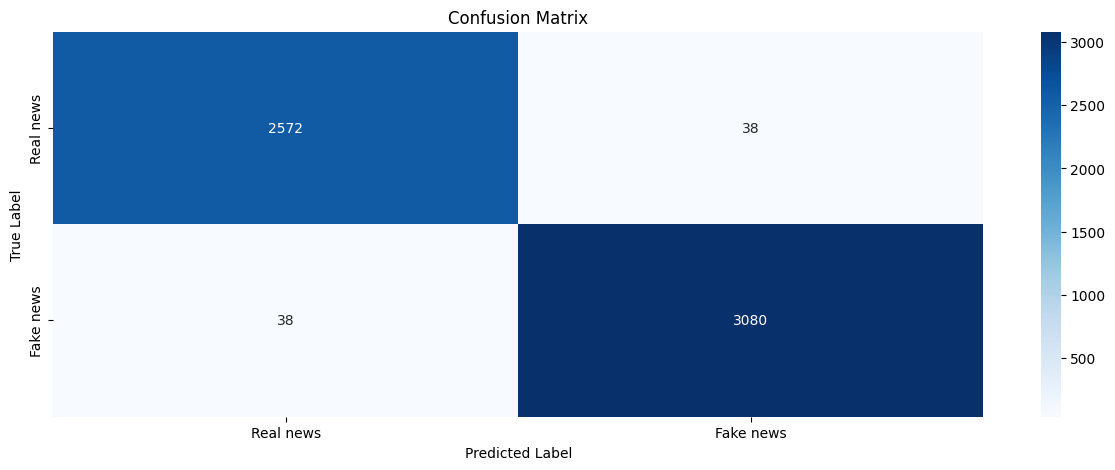

In [ ]:
plt.figure(figsize=(15, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real news', 'Fake news'], yticklabels=['Real news', 'Fake news'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Summary
We just finished the experiments, and we had some models that work fine, so here are the results.

| Name                                          | State   | Created                | Runtime               | batch_size | dataset             | dropout    | epochs | learning_rate | model_name | optimizer | warmup        | weight_decay | COMMENTS                                                                         | train_accuracy | train_f1   | train_loss | val_accuracy | val_f1    |
|-----------------------------------------------|---------|------------------------|-----------------------|------------|---------------------|------------|--------|----------------|------------|-----------|---------------|--------------|----------------------------------------------------------------------------------|-----------------|------------|------------|--------------|-----------|
| training_Fake news comments_trial_5           | finished| 2025-01-15T08:44:39.000Z | 2119                  | 8          | X_train_cleaned_2    | 0.139164306| 3      | 0.0025         | roberta-base | AdamW     | 0.192605761    | 0.01         | Some hyperparameter tunning with the clean dataset where we take out some values | 0.992647052     | 0.993222356 | 0.500407121 | 0.99563545   | 0.99598521 |
| training_Fake news comments_trial_11          | finished| 2025-01-15T12:16:48.000Z | 2115                  | 8          | X_train_cleaned_2    | 0.121825063| 3      | 0.005          | roberta-base | AdamW     | 0.198812492    | 0.005        | Some hyperparameter tunning with the clean dataset where we take out some values | 0.990403771     | 0.99113822  | 0.499249391 | 0.994238853  | 0.994712412|
| training_Fake news comments_trial_10          | finished| 2025-01-15T11:41:24.000Z | 2119                  | 8          | X_train_cleaned_2    | 0.101152313| 3      | 0.01           | roberta-base | RMSprop   | 0.050378066    | 0.0025       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.975822508     | 0.977644682 | 0.513737692 | 0.993365943  | 0.993908286|
| training_Fake news comments_trial_14          | finished| 2025-01-15T14:02:35.000Z | 2102                  | 8          | X_train_cleaned_2    | 0.17695729 | 3      | 0.0075         | roberta-base | AdamW     | 0.12553079     | 0.0025       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.986914277     | 0.98790741  | 0.500444566 | 0.991445541  | 0.992115855|
| training_Fake news comments_trial_8           | finished| 2025-01-15T10:30:43.000Z | 2115                  | 8          | X_train_cleaned_2    | 0.163192307| 3      | 1.00E-10       | roberta-base | RMSprop   | 0.164806791    | 0.0025       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.979685962     | 0.980973542 | 0.499884714 | 0.989350557  | 0.99015975 |
| training_Fake news comments_trial_7           | finished| 2025-01-15T09:55:30.000Z | 2109                  | 8          | X_train_cleaned_2    | 0.153112103| 3      | 0.005          | roberta-base | AdamW     | 0.155744489    | 1.00E-12     | Some hyperparameter tunning with the clean dataset where we take out some values | 0.987911284     | 0.988795161 | 0.499562513 | 0.989175975  | 0.99000001 |
| training_Fake news comments_trial_9           | finished| 2025-01-15T11:06:03.000Z | 2116                  | 8          | X_train_cleaned_2    | 0.267390912| 3      | 1.00E-10       | roberta-base | SGD       | 0.087466859    | 1.00E-12     | Some hyperparameter tunning with the clean dataset where we take out some values | 0.981804609     | 0.982979655 | 0.499147869 | 0.989175975  | 0.989996791|
| training_Fake news comments_trial_19          | finished| 2025-01-15T16:58:24.000Z | 2112                  | 8          | X_train_cleaned_2    | 0.103737819| 3      | 0.0025         | roberta-base | RMSprop   | 0.198571229    | 0.0025       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.984670997     | 0.985831141 | 0.501139791 | 0.989001393  | 0.98989892 |
| training_Fake news comments_trial_12          | finished| 2025-01-15T12:52:08.000Z | 2108                  | 8          | X_train_cleaned_2    | 0.138220492| 3      | 0.005          | roberta-base | RMSprop   | 0.102326563    | 0.01         | Some hyperparameter tunning with the clean dataset where we take out some values | 0.983175457     | 0.984438062 | 0.523085337 | 0.988826811  | 0.989782929|
| training_Fake news comments_trial_13          | finished| 2025-01-15T13:27:22.000Z | 2108                  | 8          | X_train_cleaned_2    | 0.203853235| 3      | 0.0025         | roberta-base | RMSprop   | 0.06864602     | 0.005        | Some hyperparameter tunning with the clean dataset where we take out some values | 0.983549356     | 0.984789133 | 0.5217755    | 0.987430155  | 0.988483667|
| training_Fake news comments_trial_6           | finished| 2025-01-15T09:20:03.000Z | 2122                  | 8          | X_train_cleaned_2    | 0.157179678| 3      | 0.0075         | roberta-base | RMSprop   | 0.01893332     | 0.0025       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.93581754      | 0.940276027 | 0.532678957 | 0.986382663  | 0.987447739|
| training_Fake news comments_trial_18          | finished| 2025-01-15T16:23:14.000Z | 2104                  | 8          | X_train_cleaned_2    | 0.226679544| 3      | 0.0075         | roberta-base | AdamW     | 0.128593306    | 0.0075       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.975822508     | 0.977644622 | 0.505577761 | 0.984113157  | 0.985310793|
| training_Fake news comments_trial_17          | finished| 2025-01-15T15:48:02.000Z | 2106                  | 8          | X_train_cleaned_2    | 0.18113853 | 3      | 0.0025         | roberta-base | RMSprop   | 0.03531496     | 0.0025       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.833001018     | 0.824607372 | 0.585337892 | 0.978177369  | 0.980123997|
| training_Fake news comments_trial_3           | finished| 2025-01-15T07:33:47.000Z | 2123                  | 8          | X_train_cleaned_2    | 0.296266823| 3      | 0.01           | roberta-base | AdamW     | 0.180375678    | 0.0075       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.961739779     | 0.964030504 | 0.526893876 | 0.914979041  | 0.9154073  |
| training_Fake news comments_trial_4           | finished| 2025-01-15T08:09:15.000Z | 2119                  | 8          | X_train_cleaned_2    | 0.266412384| 3      | 1.00E-10       | roberta-base | SGD       | 0.03196054     | 0.0075       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.867148578     | 0.860689998 | 0.54803434  | 0.914804459  | 0.91516    |
| training_Fake news comments_trial_0           | finished| 2025-01-15T05:47:23.000Z | 2118                  | 8          | X_train_cleaned_2    | 0.209490355| 3      | 1.00E-10       | roberta-base | SGD       | 0.145680462    | 0.01         | Some hyperparameter tunning with the clean dataset where we take out some values | 0.543369889     | 0.703847349 | 0.703196893 | 0.544867337  | 0.705390453|
| training_Fake news comments_trial_16          | finished| 2025-01-15T15:12:59.000Z | 2098                  | 8          | X_train_cleaned_2    | 0.143720565| 3      | 0.0075         | roberta-base | AdamW     | 0.064952648    | 0.01         | Some hyperparameter tunning with the clean dataset where we take out some values | 0.465852439     | 0.050509524 | 0.690055062 | 0.455307275  | 0           |
| training_Fake news comments_trial_15          | finished| 2025-01-15T14:37:44.000Z | 2110                  | 8          | X_train_cleaned_2    | 0.121029443| 3      | 0.0025         | roberta-base | RMSprop   | 0.003583764    | 0.005        | Some hyperparameter tunning with the clean dataset where we take out some values | 0.85792625      | 0.861212611 | 0.573258401 | 0.455132693  | 0           |
| training_Fake news comments_trial_2           | finished| 2025-01-15T06:58:20.000Z | 2122                  | 8          | X_train_cleaned_2    | 0.240679827| 3      | 1.00E-10       | roberta-base | SGD       | 0.013873458    | 0.0075       | Some hyperparameter tunning with the clean dataset where we take out some values | 0.456630111     | 0           | 0.698568747 | 0.455307275  | 0           |
| training_Fake news comments_trial_1           | finished| 2025-01-15T06:23:00.000Z | 2115                  | 8          | X_train_cleaned_2    | 0.18237484 | 3      | 0.0075         | roberta-base | SGD       | 0.10500088     | 1.00E-12     | Some hyperparameter tunning with the clean dataset where we take out some values | 0.456630111     | 0.000458505 | 0.69989593  | 0.455132693  | 0           |


We can see that some experiments work fine, so in this case, we will try to train later the same parameters but with the whole dataset hoping to get a better result.
